# QuickBite Express - Deep Analysis (Part 2)
## Sprint 2: Q4, Q5, Q6, Q7, Q9, Q10

**Questions Covered:**
- **Q4:** Cancellation rate trend pre-crisis vs crisis, most affected cities
- **Q5:** Delivery SLA compliance across phases
- **Q6:** Ratings fluctuation month-by-month
- **Q7:** Negative keyword frequency in crisis reviews (Word Cloud)
- **Q9:** Loyalty impact — churned loyal customers
- **Q10:** High-value customer decline patterns

**Input:** Cleaned datasets from `output/02_cleaned_data/`
**Output:** Charts + insights to `output/04_deep_analysis/`

---
## 0. Setup & Load Cleaned Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
from datetime import datetime
from collections import Counter
from matplotlib.patches import Patch

CLEAN_DIR = "output/02_cleaned_data/"
OUTPUT_DIR = "output/04_deep_analysis/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NAVY = "#1A2744"; TEAL = "#0D8A8A"; ORANGE = "#E8743B"; SOFT_BLUE = "#5B9BD5"
GRAY = "#888888"; RED = "#D94F4F"; GREEN = "#2ECC71"; PURPLE = "#9B59B6"
LIGHT_ORANGE = "#FFF3E0"; LIGHT_RED = "#FFEBEE"
MONTH_LABELS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

plt.rcParams.update({
    'figure.figsize': (14, 6), 'figure.facecolor': 'white', 'axes.facecolor': 'white',
    'font.family': 'sans-serif', 'font.size': 11, 'axes.titlesize': 16,
    'axes.titleweight': 'bold', 'axes.labelsize': 12, 'axes.grid': True,
    'grid.alpha': 0.3, 'grid.color': '#CCCCCC',
})
print("✅ Setup complete")

✅ Setup complete


In [2]:
print("📂 Loading cleaned datasets...")
fact_orders = pd.read_csv(f"{CLEAN_DIR}fact_orders_clean.csv", parse_dates=['order_timestamp'])
fact_order_items = pd.read_csv(f"{CLEAN_DIR}fact_order_items_clean.csv")
fact_ratings = pd.read_csv(f"{CLEAN_DIR}fact_ratings_clean.csv")
fact_delivery = pd.read_csv(f"{CLEAN_DIR}fact_delivery_performance_clean.csv")
dim_customer = pd.read_csv(f"{CLEAN_DIR}dim_customer_clean.csv")
dim_restaurant = pd.read_csv(f"{CLEAN_DIR}dim_restaurant_clean.csv")
dim_delivery_partner = pd.read_csv(f"{CLEAN_DIR}dim_delivery_partner_clean.csv")
dim_menu_item = pd.read_csv(f"{CLEAN_DIR}dim_menu_item_clean.csv")

if 'phase' not in fact_orders.columns:
    fact_orders['phase'] = fact_orders['order_timestamp'].apply(
        lambda x: 'Pre-Crisis' if x < pd.Timestamp('2025-06-01') else 'Crisis')
if 'order_month' not in fact_orders.columns:
    fact_orders['order_month'] = fact_orders['order_timestamp'].dt.to_period('M').astype(str)

print("✅ All datasets loaded")
print(f"   Orders: {len(fact_orders):,} | Ratings: {len(fact_ratings):,} | Delivery: {len(fact_delivery):,}")

📂 Loading cleaned datasets...
✅ All datasets loaded
   Orders: 149,166 | Ratings: 68,825 | Delivery: 149,166


---
## Q4: Cancellation Rate Trend & Most Affected Cities

> **Question:** What is the cancellation rate trend pre-crisis vs crisis, and which cities are most affected?

In [3]:
print("=" * 70)
print("Q4: CANCELLATION RATE ANALYSIS")
print("=" * 70)

cancel_monthly = fact_orders.groupby('order_month').agg(
    total_orders=('order_id', 'count'),
    cancelled=('is_cancelled', lambda x: (x == 'Y').sum())
).reset_index()
cancel_monthly['cancel_rate'] = (cancel_monthly['cancelled'] / cancel_monthly['total_orders'] * 100).round(2)
cancel_monthly['phase'] = cancel_monthly['order_month'].apply(lambda x: 'Pre-Crisis' if x <= '2025-05' else 'Crisis')

print("\n📊 Monthly Cancellation Rates:")
print(cancel_monthly[['order_month', 'total_orders', 'cancelled', 'cancel_rate', 'phase']].to_string(index=False))

pre_rate = fact_orders[fact_orders['phase'] == 'Pre-Crisis']['is_cancelled'].apply(lambda x: x == 'Y').mean() * 100
crisis_rate = fact_orders[fact_orders['phase'] == 'Crisis']['is_cancelled'].apply(lambda x: x == 'Y').mean() * 100
print(f"\n📋 KEY METRICS:")
print(f"   Pre-Crisis Cancel Rate:  {pre_rate:.2f}%")
print(f"   Crisis Cancel Rate:      {crisis_rate:.2f}%")
print(f"   🔴 Rate Increase:        {crisis_rate - pre_rate:.2f} pp (~{((crisis_rate/pre_rate)-1)*100:.0f}% increase)")

Q4: CANCELLATION RATE ANALYSIS

📊 Monthly Cancellation Rates:
order_month  total_orders  cancelled  cancel_rate      phase
    2025-01         23539       1463         6.22 Pre-Crisis
    2025-02         22667       1395         6.15 Pre-Crisis
    2025-03         23543       1410         5.99 Pre-Crisis
    2025-04         21466       1256         5.85 Pre-Crisis
    2025-05         22591       1370         6.06 Pre-Crisis
    2025-06          9293       1074        11.56     Crisis
    2025-07          8818       1050        11.91     Crisis
    2025-08          8555       1070        12.51     Crisis
    2025-09          8694       1024        11.78     Crisis

📋 KEY METRICS:
   Pre-Crisis Cancel Rate:  6.06%
   Crisis Cancel Rate:      11.93%
   🔴 Rate Increase:        5.87 pp (~97% increase)


In [4]:
# City-wise cancellation
orders_city = fact_orders.merge(dim_restaurant[['restaurant_id', 'city']], on='restaurant_id', how='left')
city_cancel = orders_city.groupby(['city', 'phase']).agg(
    total=('order_id', 'count'), cancelled=('is_cancelled', lambda x: (x == 'Y').sum())
).reset_index()
city_cancel['cancel_rate'] = (city_cancel['cancelled'] / city_cancel['total'] * 100).round(2)
city_cancel_pivot = city_cancel.pivot(index='city', columns='phase', values='cancel_rate').reset_index()
city_cancel_pivot['rate_increase'] = (city_cancel_pivot['Crisis'] - city_cancel_pivot['Pre-Crisis']).round(2)
city_cancel_pivot = city_cancel_pivot.sort_values('Crisis', ascending=False)
print("📊 City-wise Cancellation Rates:")
print(city_cancel_pivot.to_string(index=False))

📊 City-wise Cancellation Rates:
     city  Crisis  Pre-Crisis  rate_increase
Ahmedabad   13.03        6.08           6.95
   Mumbai   12.35        5.87           6.48
  Chennai   12.19        6.07           6.12
Hyderabad   12.09        6.10           5.99
  Kolkata   11.97        5.86           6.11
Bengaluru   11.76        6.17           5.59
     Pune   11.62        6.00           5.62
    Delhi   11.05        6.16           4.89


C:\Users\surendhar b\AppData\Local\Temp\ipykernel_15908\3326781232.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MONTH_LABELS)


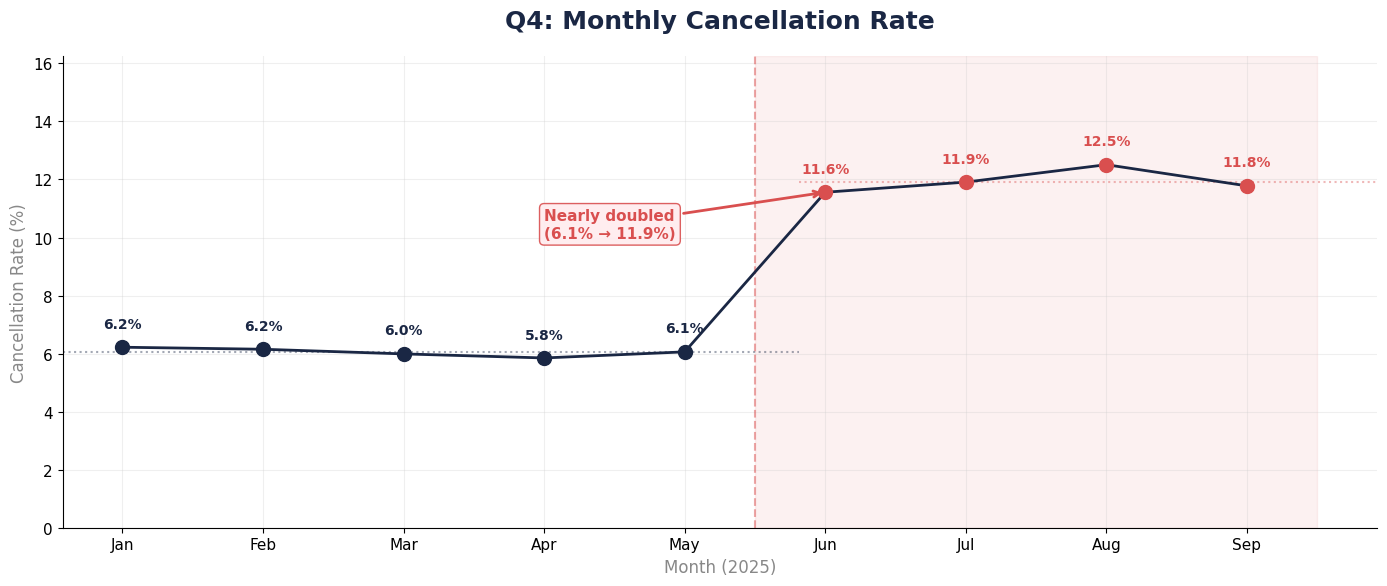

✅ Chart saved: Q4a_cancellation_trend.png


In [5]:
# CHART Q4a: Monthly Cancellation Rate Trend
fig, ax = plt.subplots(figsize=(14, 6))
months = cancel_monthly['order_month'].values
rates = cancel_monthly['cancel_rate'].values

ax.plot(months, rates, color=NAVY, linewidth=2, marker='o', markersize=8, zorder=3)
for i, (m, r) in enumerate(zip(months, rates)):
    color = NAVY if m <= '2025-05' else RED
    ax.plot(m, r, 'o', color=color, markersize=10, zorder=4)
    ax.annotate(f'{r:.1f}%', (m, r), textcoords='offset points', xytext=(0, 14),
                ha='center', fontsize=10, fontweight='bold', color=color)

ax.axvspan(4.5, 8.5, alpha=0.08, color=RED, zorder=0)
ax.axvline(x=4.5, color=RED, linestyle='--', alpha=0.5, linewidth=1.5)
ax.axhline(y=pre_rate, xmin=0, xmax=0.56, color=NAVY, linestyle=':', alpha=0.4)
ax.axhline(y=crisis_rate, xmin=0.56, xmax=1, color=RED, linestyle=':', alpha=0.4)

ax.annotate(f'Nearly doubled\n({pre_rate:.1f}% → {crisis_rate:.1f}%)', xy=(5, rates[5]),
            xytext=(3, 10), fontsize=11, fontweight='bold', color=RED,
            arrowprops=dict(arrowstyle='->', color=RED, lw=2),
            bbox=dict(boxstyle='round,pad=0.3', facecolor=LIGHT_RED, edgecolor=RED, alpha=0.9))

ax.set_title('Q4: Monthly Cancellation Rate', fontsize=18, fontweight='bold', color=NAVY, pad=20)
ax.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax.set_ylabel('Cancellation Rate (%)', fontsize=12, color=GRAY)
ax.set_xticklabels(MONTH_LABELS)
ax.set_ylim(0, max(rates) * 1.3)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q4a_cancellation_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q4a_cancellation_trend.png")

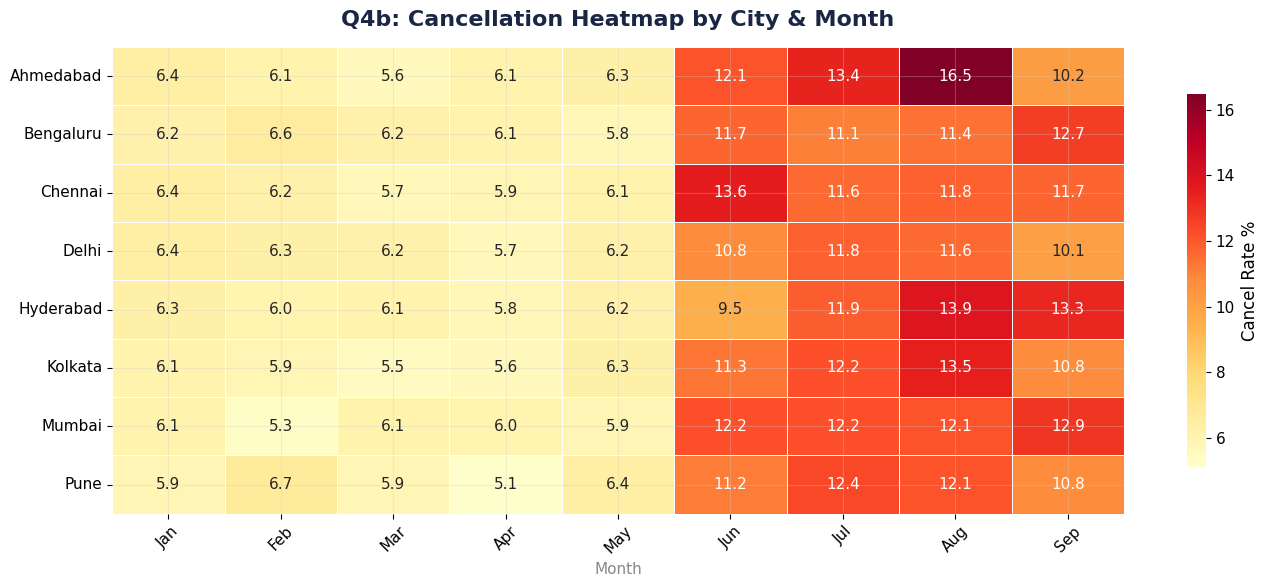

✅ Chart saved: Q4b_city_cancellation_heatmap.png


In [6]:
# CHART Q4b: City-wise Heatmap
orders_city['order_month'] = orders_city['order_timestamp'].dt.to_period('M').astype(str)
city_month_cancel = orders_city.groupby(['city', 'order_month']).agg(
    total=('order_id', 'count'), cancelled=('is_cancelled', lambda x: (x == 'Y').sum())
).reset_index()
city_month_cancel['rate'] = (city_month_cancel['cancelled'] / city_month_cancel['total'] * 100).round(1)
heatmap_data = city_month_cancel.pivot(index='city', columns='order_month', values='rate')

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'Cancel Rate %', 'shrink': 0.8}, linewidths=0.5, linecolor='white')
ax.set_title('Q4b: Cancellation Heatmap by City & Month', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax.set_xlabel('Month', fontsize=11, color=GRAY); ax.set_ylabel('')
ax.set_xticklabels(MONTH_LABELS, rotation=45)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q4b_city_cancellation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q4b_city_cancellation_heatmap.png")

### Q4 Insight Summary

**Finding:** Cancellation rate nearly **doubled** from ~6.1% (pre-crisis) to ~11.9% (crisis).

- Cancellations spiked immediately in June and stayed elevated through September.
- **Ahmedabad (13.0%)** and **Mumbai (12.4%)** had the highest crisis cancellation rates.
- The sustained rate suggests ongoing operational issues, not a one-time spike.

---
## Q5: Delivery SLA Compliance Across Phases

> **Question:** Measure average delivery time across phases. Did SLA compliance worsen significantly?

In [7]:
print("=" * 70)
print("Q5: DELIVERY SLA COMPLIANCE")
print("=" * 70)

orders_del = fact_orders.merge(fact_delivery, on='order_id', how='left')
orders_del['sla_breach'] = (orders_del['actual_delivery_time_mins'] > orders_del['expected_delivery_time_mins']).astype(int)
orders_del['delay_mins'] = orders_del['actual_delivery_time_mins'] - orders_del['expected_delivery_time_mins']

sla_monthly = orders_del.groupby('order_month').agg(
    avg_actual=('actual_delivery_time_mins', 'mean'), avg_expected=('expected_delivery_time_mins', 'mean'),
    avg_delay=('delay_mins', 'mean'), breach_count=('sla_breach', 'sum'), total=('order_id', 'count')
).reset_index()
sla_monthly['breach_rate'] = (sla_monthly['breach_count'] / sla_monthly['total'] * 100).round(2)

print("\n📊 Monthly SLA Metrics:")
print(sla_monthly[['order_month', 'avg_actual', 'avg_expected', 'avg_delay', 'breach_rate']].round(1).to_string(index=False))

for phase in ['Pre-Crisis', 'Crisis']:
    df = orders_del[orders_del['phase'] == phase]
    print(f"\n📋 {phase}: Avg Actual={df['actual_delivery_time_mins'].mean():.1f}min, "
          f"Avg Expected={df['expected_delivery_time_mins'].mean():.1f}min, "
          f"SLA Breach={df['sla_breach'].mean()*100:.1f}%")

Q5: DELIVERY SLA COMPLIANCE

📊 Monthly SLA Metrics:
order_month  avg_actual  avg_expected  avg_delay  breach_rate
    2025-01        39.6          37.5        2.1         56.8
    2025-02        39.5          37.5        2.0         56.0
    2025-03        39.4          37.5        1.9         55.7
    2025-04        39.6          37.5        2.1         56.6
    2025-05        39.6          37.5        2.1         56.9
    2025-06        60.3          42.5       17.8         88.2
    2025-07        59.9          42.5       17.5         87.4
    2025-08        60.1          42.5       17.5         87.7
    2025-09        60.1          42.5       17.6         87.8

📋 Pre-Crisis: Avg Actual=39.5min, Avg Expected=37.5min, SLA Breach=56.4%

📋 Crisis: Avg Actual=60.1min, Avg Expected=42.5min, SLA Breach=87.8%


C:\Users\surendhar b\AppData\Local\Temp\ipykernel_15908\3525828329.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(MONTH_LABELS)


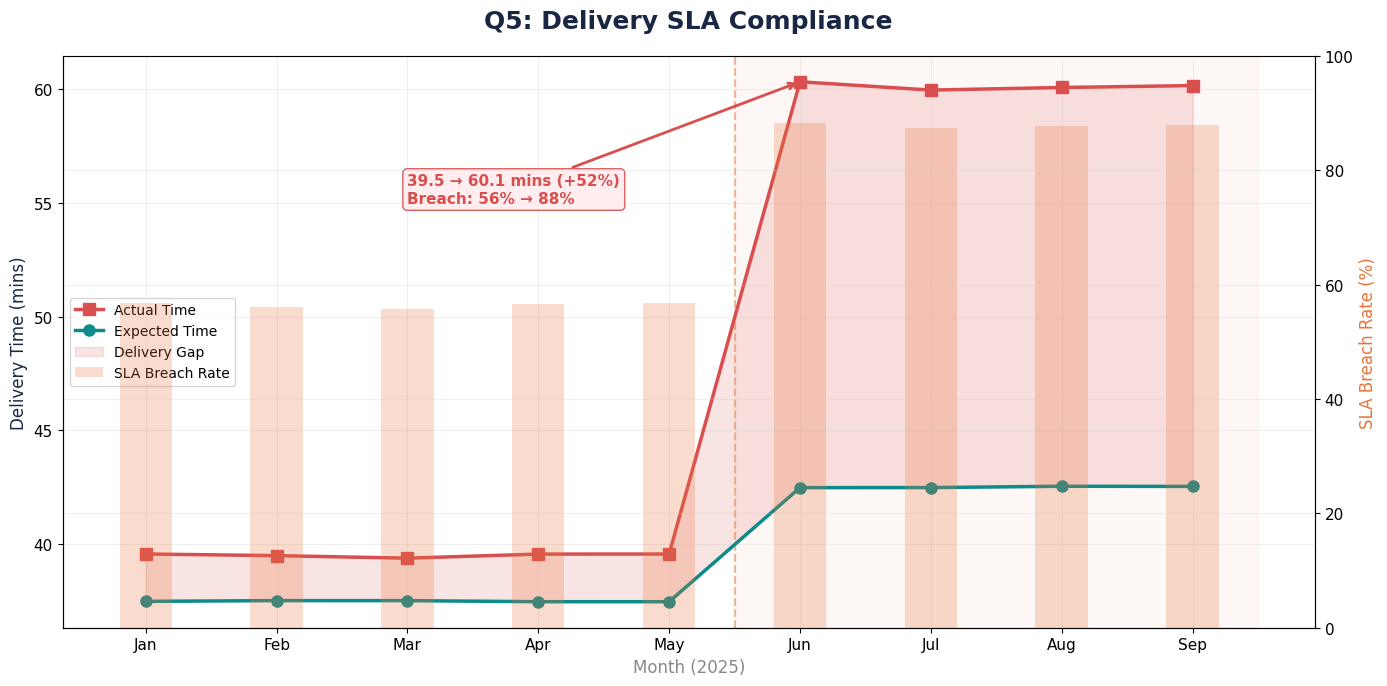

✅ Chart saved: Q5_sla_compliance.png


In [8]:
# CHART Q5: Dual-Axis Delivery Time + SLA Breach Rate
fig, ax1 = plt.subplots(figsize=(14, 7))
months = sla_monthly['order_month'].values

ax1.plot(months, sla_monthly['avg_actual'], color=RED, linewidth=2.5, marker='s', markersize=8, label='Actual Time', zorder=3)
ax1.plot(months, sla_monthly['avg_expected'], color=TEAL, linewidth=2.5, marker='o', markersize=8, label='Expected Time', zorder=3)
ax1.fill_between(months, sla_monthly['avg_expected'], sla_monthly['avg_actual'], alpha=0.15, color=RED, label='Delivery Gap')

ax2 = ax1.twinx()
ax2.bar(months, sla_monthly['breach_rate'], alpha=0.25, color=ORANGE, width=0.4, label='SLA Breach Rate', zorder=1)
ax2.set_ylabel('SLA Breach Rate (%)', fontsize=12, color=ORANGE)
ax2.set_ylim(0, 100)

ax1.axvspan(4.5, 8.5, alpha=0.05, color=ORANGE, zorder=0)
ax1.axvline(x=4.5, color=ORANGE, linestyle='--', alpha=0.5)

ax1.annotate('39.5 → 60.1 mins (+52%)\nBreach: 56% → 88%', xy=(5, sla_monthly.iloc[5]['avg_actual']),
             xytext=(2, 55), fontsize=11, fontweight='bold', color=RED,
             arrowprops=dict(arrowstyle='->', color=RED, lw=2),
             bbox=dict(boxstyle='round,pad=0.3', facecolor=LIGHT_RED, edgecolor=RED, alpha=0.9))

ax1.set_title('Q5: Delivery SLA Compliance', fontsize=18, fontweight='bold', color=NAVY, pad=20)
ax1.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax1.set_ylabel('Delivery Time (mins)', fontsize=12, color=NAVY)
ax1.set_xticklabels(MONTH_LABELS)
ax1.spines['top'].set_visible(False)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q5_sla_compliance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q5_sla_compliance.png")

### Q5 Insight Summary

**Finding:** SLA breach rate jumped from **56% to 88%**. Actual delivery time increased from **39.5 to 60.1 minutes (+52%)**.

- The monsoon delivery outage devastated operations.
- Even pre-crisis breach rate (~56%) was concerning — now catastrophic at 88%.
- Fixing delivery infrastructure is critical for recovery.

---
## Q6: Ratings Fluctuation Month-by-Month

> **Question:** Track average customer rating month-by-month. Which months saw the sharpest drop?

In [9]:
print("=" * 70)
print("Q6: RATINGS FLUCTUATION")
print("=" * 70)

ratings_monthly = fact_ratings.merge(fact_orders[['order_id', 'order_month', 'phase']], on='order_id', how='left')
monthly_rating = ratings_monthly.groupby('order_month').agg(
    avg_rating=('rating', 'mean'), avg_sentiment=('sentiment_score', 'mean'),
    review_count=('order_id', 'count')
).reset_index()
monthly_rating['mom_change'] = monthly_rating['avg_rating'].diff().round(3)

print("\n📊 Monthly Rating Trends:")
print(monthly_rating[['order_month', 'avg_rating', 'avg_sentiment', 'review_count', 'mom_change']].round(2).to_string(index=False))

sharpest_idx = monthly_rating['mom_change'].idxmin()
sharpest = monthly_rating.loc[sharpest_idx]
print(f"\n🔴 Sharpest Drop: {sharpest['order_month']} (change: {sharpest['mom_change']:.2f})")

Q6: RATINGS FLUCTUATION

📊 Monthly Rating Trends:
order_month  avg_rating  avg_sentiment  review_count  mom_change
    2025-01        4.58           0.79         11020         NaN
    2025-02        4.40           0.70         10580       -0.18
    2025-03        4.74           0.87         10984        0.34
    2025-04        4.29           0.65         10129       -0.45
    2025-05        4.49           0.75         10620        0.20
    2025-06        2.58          -0.21          4095       -1.91
    2025-07        2.69          -0.15          3884        0.10
    2025-08        2.40          -0.30          3676       -0.29
    2025-09        2.31          -0.35          3837       -0.10

🔴 Sharpest Drop: 2025-06 (change: -1.91)


C:\Users\surendhar b\AppData\Local\Temp\ipykernel_15908\3277330737.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(MONTH_LABELS); ax1.set_ylim(1.5, 5.5)


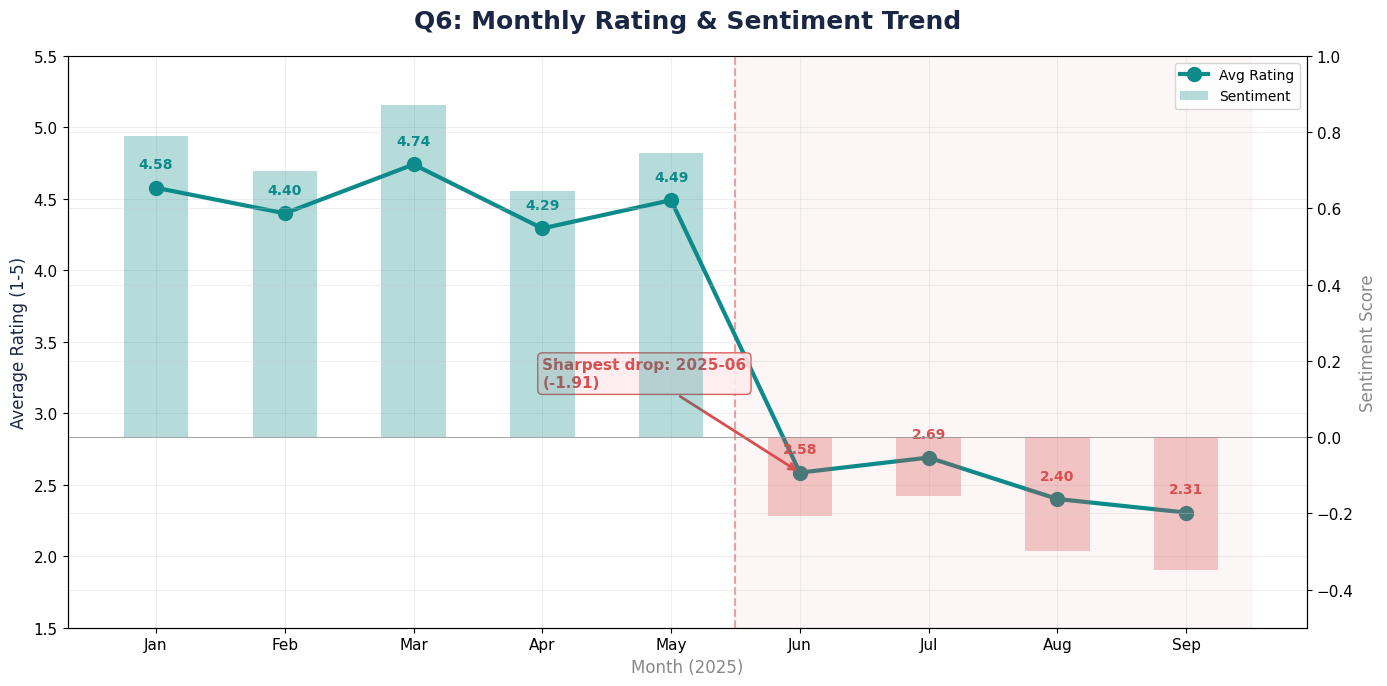

✅ Chart saved: Q6_rating_trend.png


In [10]:
# CHART Q6: Monthly Avg Rating + Sentiment
fig, ax1 = plt.subplots(figsize=(14, 7))
months = monthly_rating['order_month'].values
ratings_vals = monthly_rating['avg_rating'].values
sentiment_vals = monthly_rating['avg_sentiment'].values

ax1.plot(months, ratings_vals, color=TEAL, linewidth=3, marker='o', markersize=10, label='Avg Rating', zorder=3)
for i, (m, r) in enumerate(zip(months, ratings_vals)):
    color = TEAL if m <= '2025-05' else RED
    ax1.annotate(f'{r:.2f}', (m, r), textcoords='offset points', xytext=(0, 14),
                 ha='center', fontsize=10, fontweight='bold', color=color)

ax2 = ax1.twinx()
ax2.bar(months, sentiment_vals, alpha=0.3, width=0.5,
        color=[TEAL if s >= 0 else RED for s in sentiment_vals], label='Sentiment', zorder=1)
ax2.set_ylabel('Sentiment Score', fontsize=12, color=GRAY)
ax2.axhline(y=0, color=GRAY, linestyle='-', linewidth=0.5)
ax2.set_ylim(-0.5, 1.0)

ax1.axvspan(4.5, 8.5, alpha=0.05, color=RED, zorder=0)
ax1.axvline(x=4.5, color=RED, linestyle='--', alpha=0.5)

ax1.annotate(f'Sharpest drop: {sharpest["order_month"]}\n({sharpest["mom_change"]:+.2f})',
             xy=(sharpest_idx, ratings_vals[sharpest_idx]),
             xytext=(sharpest_idx - 2, ratings_vals[sharpest_idx] + 0.6),
             fontsize=11, fontweight='bold', color=RED,
             arrowprops=dict(arrowstyle='->', color=RED, lw=2),
             bbox=dict(boxstyle='round,pad=0.3', facecolor=LIGHT_RED, edgecolor=RED, alpha=0.9))

ax1.set_title('Q6: Monthly Rating & Sentiment Trend', fontsize=18, fontweight='bold', color=NAVY, pad=20)
ax1.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax1.set_ylabel('Average Rating (1-5)', fontsize=12, color=NAVY)
ax1.set_xticklabels(MONTH_LABELS); ax1.set_ylim(1.5, 5.5)
ax1.spines['top'].set_visible(False)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q6_rating_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q6_rating_trend.png")

### Q6 Insight Summary

**Finding:** Average rating crashed from **~4.5 stars to ~2.5 stars** — a 2-star drop. Sentiment went from +0.75 to -0.25.

- Ratings continued declining through Sep (2.31) — problem is worsening.
- Distribution completely flipped from majority 4-5 stars to majority 1-2 stars.

---
## Q7: Negative Keyword Frequency — Word Cloud

> **Question:** During the crisis period, identify the most frequently occurring negative keywords in customer review texts.

In [11]:
print("=" * 70)
print("Q7: NEGATIVE KEYWORD ANALYSIS")
print("=" * 70)

crisis_reviews = ratings_monthly[ratings_monthly['phase'] == 'Crisis']
neg_reviews = crisis_reviews[crisis_reviews['sentiment_score'] < 0]
print(f"\nCrisis Reviews: {len(crisis_reviews):,} | Negative: {len(neg_reviews):,} ({len(neg_reviews)/len(crisis_reviews)*100:.1f}%)")

stopwords = {'the','is','was','a','an','and','or','but','in','on','at','to','for','of','with',
             'it','not','this','that','i','my','me','very','than','so','too','be','been','being',
             'have','has','had','do','does','did','will','would','could','should','no'}

words = []
for text in neg_reviews['review_text'].dropna():
    for word in text.lower().split():
        w = word.strip('.,!?;:')
        if w and w not in stopwords and len(w) > 2:
            words.append(w)

word_freq = Counter(words)
print(f"\n🔝 Top 20 Negative Keywords:")
for word, count in word_freq.most_common(20):
    bar = '█' * int(count / 100)
    print(f"   {word:<20} {count:>5} {bar}")

Q7: NEGATIVE KEYWORD ANALYSIS

Crisis Reviews: 15,492 | Negative: 11,891 (76.8%)

🔝 Top 20 Negative Keywords:
   food                  4941 █████████████████████████████████████████████████
   quality               2226 ██████████████████████
   issue                 2073 ████████████████████
   packaging             1627 ████████████████
   good                  1596 ███████████████
   safety                1076 ██████████
   bad                    972 █████████
   taste                  972 █████████
   stale                  971 █████████
   served                 971 █████████
   recommended            942 █████████
   late                   904 █████████
   cold                   668 ██████
   portion                658 ██████
   size                   658 ██████
   smaller                658 ██████
   expected               658 ██████
   worth                  655 ██████
   price                  655 ██████
   average                645 ██████


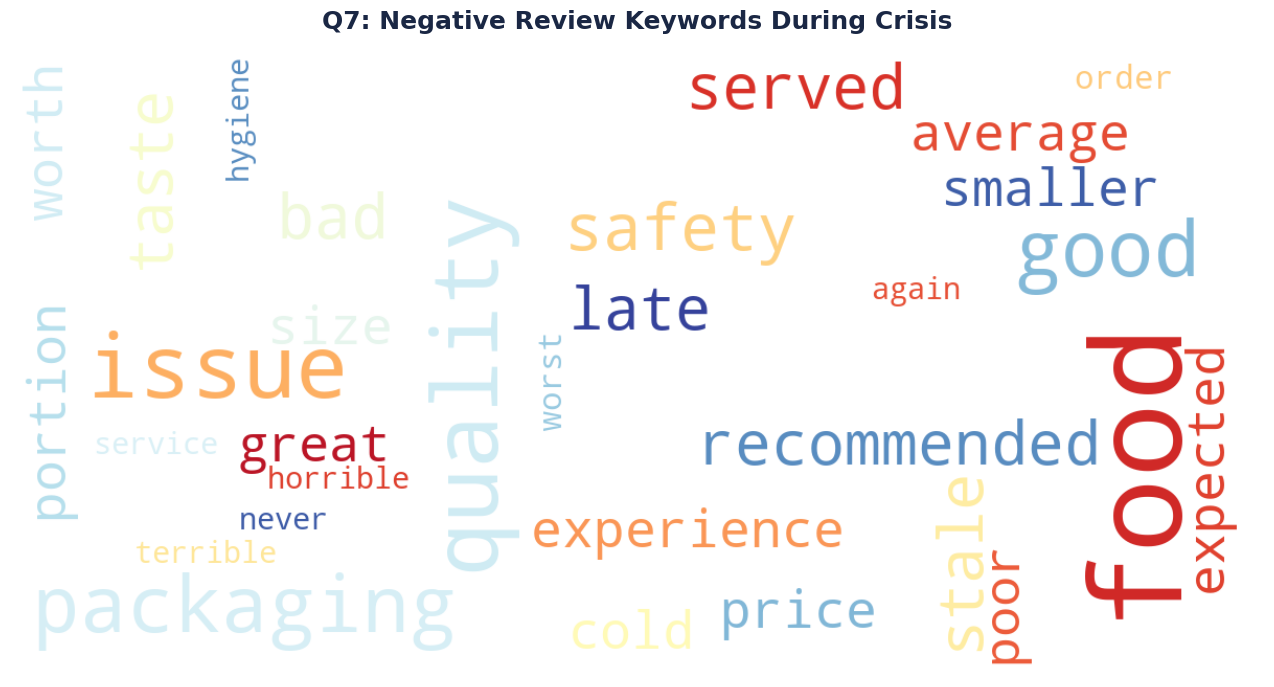

✅ Chart saved: Q7a_word_cloud.png


In [12]:
# CHART Q7a: Word Cloud
try:
    from wordcloud import WordCloud
    wc = WordCloud(width=1200, height=600, background_color='white', colormap='RdYlBu_r',
                   max_words=80, max_font_size=120, min_font_size=12, prefer_horizontal=0.7, relative_scaling=0.5)
    wc.generate_from_frequencies(word_freq)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(wc, interpolation='bilinear'); ax.axis('off')
    ax.set_title('Q7: Negative Review Keywords During Crisis', fontsize=18, fontweight='bold', color=NAVY, pad=15)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}Q7a_word_cloud.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Chart saved: Q7a_word_cloud.png")
except ImportError:
    print("⚠️ wordcloud not installed. Run: pip install wordcloud")

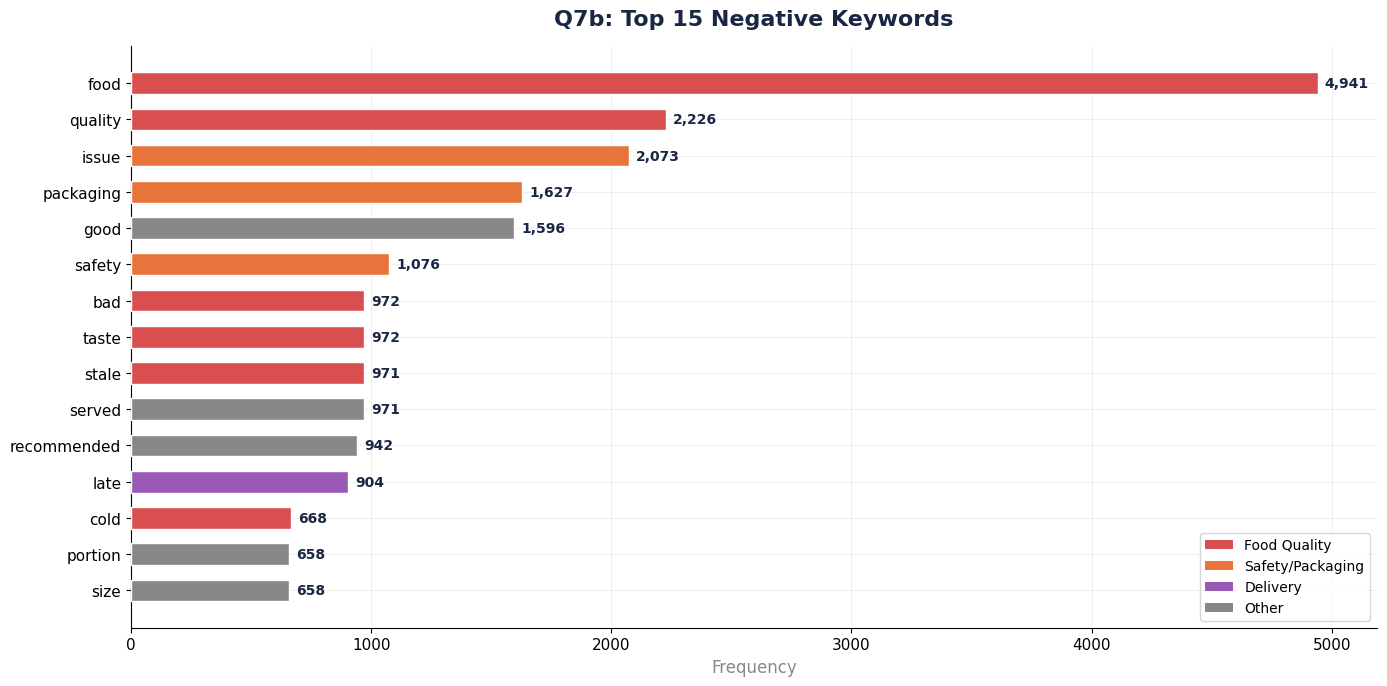

✅ Chart saved: Q7b_keyword_frequency.png


In [13]:
# CHART Q7b: Keyword Bar Chart
fig, ax = plt.subplots(figsize=(14, 7))
top_words = word_freq.most_common(15)
words_list = [w[0] for w in top_words][::-1]
counts_list = [w[1] for w in top_words][::-1]

food_words = {'food','quality','stale','cold','taste','bad'}
safety_words = {'safety','issue','packaging'}
delivery_words = {'late','delivery','delayed'}

bar_colors = []
for w in words_list:
    if w in food_words: bar_colors.append(RED)
    elif w in safety_words: bar_colors.append(ORANGE)
    elif w in delivery_words: bar_colors.append(PURPLE)
    else: bar_colors.append(GRAY)

bars = ax.barh(words_list, counts_list, color=bar_colors, height=0.6, edgecolor='white', zorder=3)
for bar, val in zip(bars, counts_list):
    ax.text(bar.get_width() + 30, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontsize=10, fontweight='bold', color=NAVY)

legend_elements = [Patch(facecolor=RED, label='Food Quality'), Patch(facecolor=ORANGE, label='Safety/Packaging'),
                   Patch(facecolor=PURPLE, label='Delivery'), Patch(facecolor=GRAY, label='Other')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
ax.set_title('Q7b: Top 15 Negative Keywords', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax.set_xlabel('Frequency', fontsize=12, color=GRAY)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q7b_keyword_frequency.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q7b_keyword_frequency.png")

### Q7 Insight Summary

**Finding:** Dominant complaints: **food quality** (food, quality, stale, cold), **safety** (safety, issue, packaging), and **delivery** (late).

- "food" and "quality" overwhelmingly top — this is a food trust crisis.
- "safety" and "stale" directly align with the viral food safety incident.
- Recovery messaging must center on food safety audits, quality guarantees.

---
## Q9: Loyalty Impact — Churned Loyal Customers

> **Question:** Among customers who placed 5+ orders before the crisis, how many stopped ordering during the crisis? Of those, how many had avg rating above 4.5?

In [14]:
print("=" * 70)
print("Q9: LOYALTY IMPACT")
print("=" * 70)

pre_crisis = fact_orders[fact_orders['phase'] == 'Pre-Crisis']
crisis = fact_orders[fact_orders['phase'] == 'Crisis']

pre_cust_counts = pre_crisis.groupby('customer_id').size().reset_index(name='pre_orders')
loyal_customers = pre_cust_counts[pre_cust_counts['pre_orders'] >= 5].copy()
print(f"\nLoyal Customers (5+ pre-crisis orders): {len(loyal_customers):,}")

crisis_customer_ids = set(crisis['customer_id'].unique())
loyal_customers['churned'] = ~loyal_customers['customer_id'].isin(crisis_customer_ids)

churned = loyal_customers[loyal_customers['churned']]
active = loyal_customers[~loyal_customers['churned']]
print(f"Churned: {len(churned):,} ({len(churned)/len(loyal_customers)*100:.1f}%)")
print(f"Still Active: {len(active):,}")

# High-rating churners
churned_ratings = fact_ratings[fact_ratings['customer_id'].isin(churned['customer_id'])]
churned_avg = churned_ratings.groupby('customer_id')['rating'].mean().reset_index(name='avg_rating')
high_rating_churners = churned_avg[churned_avg['avg_rating'] > 4.5]

print(f"\n📋 KEY METRICS:")
print(f"   Loyal Customers:            {len(loyal_customers):,}")
print(f"   Churned During Crisis:      {len(churned):,} ({len(churned)/len(loyal_customers)*100:.1f}%)")
print(f"   🔴 High-Rating Churners:    {len(high_rating_churners):,} (avg > 4.5)")
print(f"   ⚠️ These were SATISFIED customers who left — highest recovery potential!")

Q9: LOYALTY IMPACT

Loyal Customers (5+ pre-crisis orders): 58
Churned: 49 (84.5%)
Still Active: 9

📋 KEY METRICS:
   Loyal Customers:            58
   Churned During Crisis:      49 (84.5%)
   🔴 High-Rating Churners:    26 (avg > 4.5)
   ⚠️ These were SATISFIED customers who left — highest recovery potential!


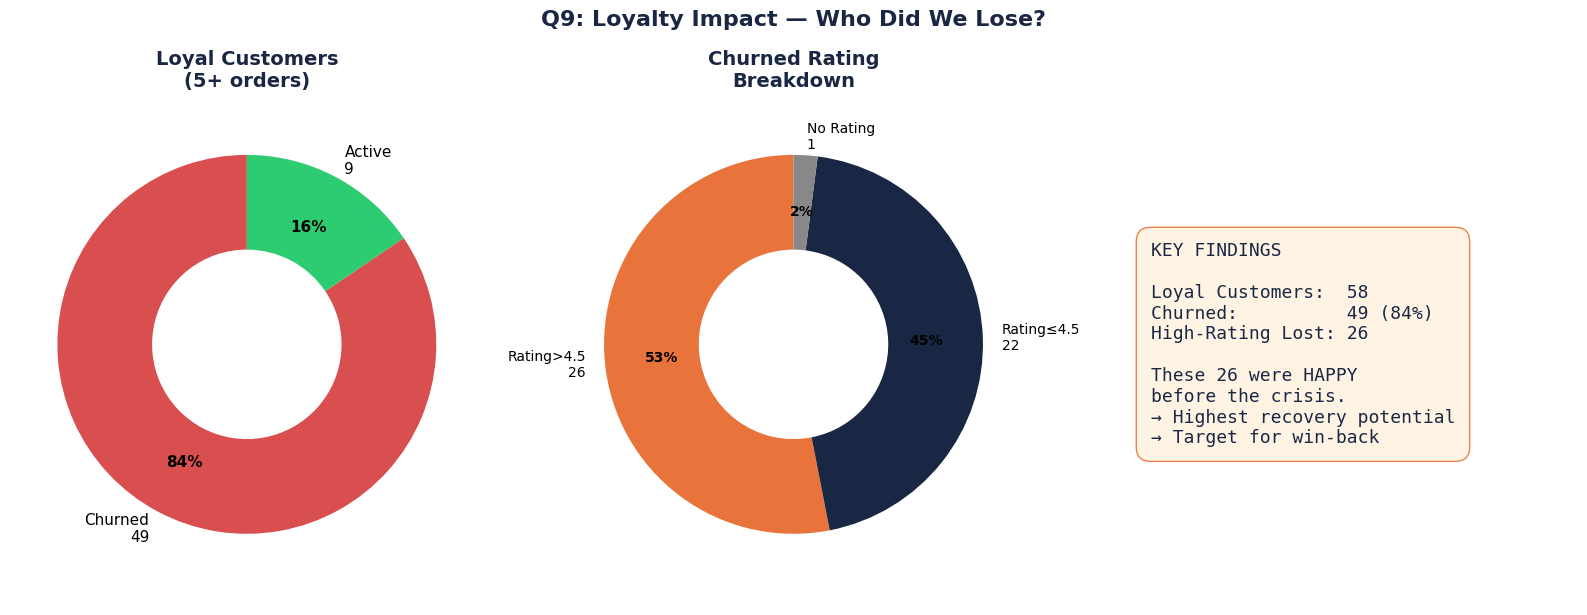

✅ Chart saved: Q9_loyalty_impact.png


In [15]:
# CHART Q9: Loyalty Impact
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Left: Churn donut
ax1 = axes[0]
sizes = [len(churned), len(active)]
labels = [f'Churned\n{len(churned)}', f'Active\n{len(active)}']
wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=[RED, GREEN], autopct='%1.0f%%',
    startangle=90, textprops={'fontsize': 11}, pctdistance=0.7, wedgeprops=dict(width=0.5))
for a in autotexts: a.set_fontweight('bold')
ax1.set_title('Loyal Customers\n(5+ orders)', fontsize=14, fontweight='bold', color=NAVY, pad=15)

# Middle: High-rating churners
ax2 = axes[1]
high_ct = len(high_rating_churners)
low_ct = len(churned_avg) - high_ct
no_data = len(churned) - len(churned_avg)
wedges2, texts2, autotexts2 = ax2.pie([high_ct, low_ct, no_data],
    labels=[f'Rating>4.5\n{high_ct}', f'Rating≤4.5\n{low_ct}', f'No Rating\n{no_data}'],
    colors=[ORANGE, NAVY, GRAY], autopct='%1.0f%%', startangle=90,
    textprops={'fontsize': 10}, pctdistance=0.7, wedgeprops=dict(width=0.5))
for a in autotexts2: a.set_fontweight('bold')
ax2.set_title('Churned Rating\nBreakdown', fontsize=14, fontweight='bold', color=NAVY, pad=15)

# Right: KPI text
ax3 = axes[2]; ax3.axis('off')
kpi = f"KEY FINDINGS\n\nLoyal Customers:  {len(loyal_customers)}\nChurned:          {len(churned)} ({len(churned)/len(loyal_customers)*100:.0f}%)\nHigh-Rating Lost: {len(high_rating_churners)}\n\nThese {len(high_rating_churners)} were HAPPY\nbefore the crisis.\n→ Highest recovery potential\n→ Target for win-back"
ax3.text(0.1, 0.5, kpi, transform=ax3.transAxes, fontsize=13, verticalalignment='center',
         fontfamily='monospace', color=NAVY,
         bbox=dict(boxstyle='round,pad=0.8', facecolor=LIGHT_ORANGE, edgecolor=ORANGE, alpha=0.9))

fig.suptitle('Q9: Loyalty Impact — Who Did We Lose?', fontsize=16, fontweight='bold', color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q9_loyalty_impact.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q9_loyalty_impact.png")

### Q9 Insight Summary

**Finding:** Of 58 loyal customers, **49 churned (84.5%)**. **26 had avg rating > 4.5** — happy customers who left.

- The crisis hit loyal customers hardest — 84.5% stopped ordering.
- 26 high-rating churners = best win-back targets.
- Personalized campaigns (cashback, free delivery) should prioritize these.

---
## Q10: High-Value Customer Decline Patterns

> **Question:** Which high-value customers (top 5% by total spend) showed the largest drop in order frequency and ratings? What patterns do they share?

In [16]:
print("=" * 70)
print("Q10: HIGH-VALUE CUSTOMER DECLINE PATTERNS")
print("=" * 70)

pre_spend = pre_crisis.groupby('customer_id')['total_amount'].sum().reset_index(name='pre_total_spend')
threshold_95 = pre_spend['pre_total_spend'].quantile(0.95)
top5pct = pre_spend[pre_spend['pre_total_spend'] >= threshold_95].copy()
top_ids = set(top5pct['customer_id'])

print(f"\nTop 5% Threshold: ₹{threshold_95:,.2f}")
print(f"Top 5% Customers: {len(top5pct):,}")

# Crisis behavior
pre_freq = pre_crisis[pre_crisis['customer_id'].isin(top_ids)].groupby('customer_id').size().reset_index(name='pre_freq')
crisis_freq = crisis[crisis['customer_id'].isin(top_ids)].groupby('customer_id').size().reset_index(name='crisis_freq')

top_analysis = top5pct.merge(pre_freq, on='customer_id', how='left')
top_analysis = top_analysis.merge(crisis_freq, on='customer_id', how='left')
top_analysis['crisis_freq'] = top_analysis['crisis_freq'].fillna(0).astype(int)
top_analysis['churned'] = top_analysis['crisis_freq'] == 0

churned_ct = top_analysis['churned'].sum()
active_ct = len(top_analysis) - churned_ct
print(f"Top 5% who CHURNED: {churned_ct:,} ({churned_ct/len(top_analysis)*100:.1f}%)")
print(f"Top 5% still active: {active_ct:,}")

Q10: HIGH-VALUE CUSTOMER DECLINE PATTERNS

Top 5% Threshold: ₹923.45
Top 5% Customers: 4,342
Top 5% who CHURNED: 3,648 (84.0%)
Top 5% still active: 694


In [17]:
# Rating decline for top 5%
top_ratings = fact_ratings[fact_ratings['customer_id'].isin(top_ids)]
top_ratings = top_ratings.merge(fact_orders[['order_id', 'phase']], on='order_id', how='left')
pre_avg_r = top_ratings[top_ratings['phase'] == 'Pre-Crisis'].groupby('customer_id')['rating'].mean()
crisis_avg_r = top_ratings[top_ratings['phase'] == 'Crisis'].groupby('customer_id')['rating'].mean()

print(f"⭐ Rating Decline (Top 5%):")
print(f"   Pre-Crisis Avg: {pre_avg_r.mean():.2f}")
print(f"   Crisis Avg:     {crisis_avg_r.mean():.2f}")
print(f"   Drop:           {pre_avg_r.mean() - crisis_avg_r.mean():.2f} stars")

# Patterns
top_orders = fact_orders[fact_orders['customer_id'].isin(top_ids)]
top_rest = top_orders.merge(dim_restaurant[['restaurant_id', 'city', 'cuisine_type']], on='restaurant_id', how='left')
top_del = top_orders.merge(fact_delivery, on='order_id', how='left')
top_del['delay'] = top_del['actual_delivery_time_mins'] - top_del['expected_delivery_time_mins']

print(f"\n📍 Top Cities: {top_rest['city'].value_counts().head(3).to_dict()}")
print(f"🍽️ Top Cuisines: {top_rest['cuisine_type'].value_counts().head(3).to_dict()}")
for phase in ['Pre-Crisis', 'Crisis']:
    d = top_del[top_del['phase'] == phase]
    print(f"🚗 {phase}: Avg Delivery={d['actual_delivery_time_mins'].mean():.1f}min, Breach={((d['delay']>0).mean()*100):.1f}%")

⭐ Rating Decline (Top 5%):
   Pre-Crisis Avg: 4.51
   Crisis Avg:     2.51
   Drop:           2.00 stars

📍 Top Cities: {'Bengaluru': 3019, 'Mumbai': 1940, 'Delhi': 1907}
🍽️ Top Cuisines: {'North Indian': 2474, 'Biryani': 1911, 'Chinese': 1872}
🚗 Pre-Crisis: Avg Delivery=39.4min, Breach=55.6%
🚗 Crisis: Avg Delivery=59.6min, Breach=86.9%


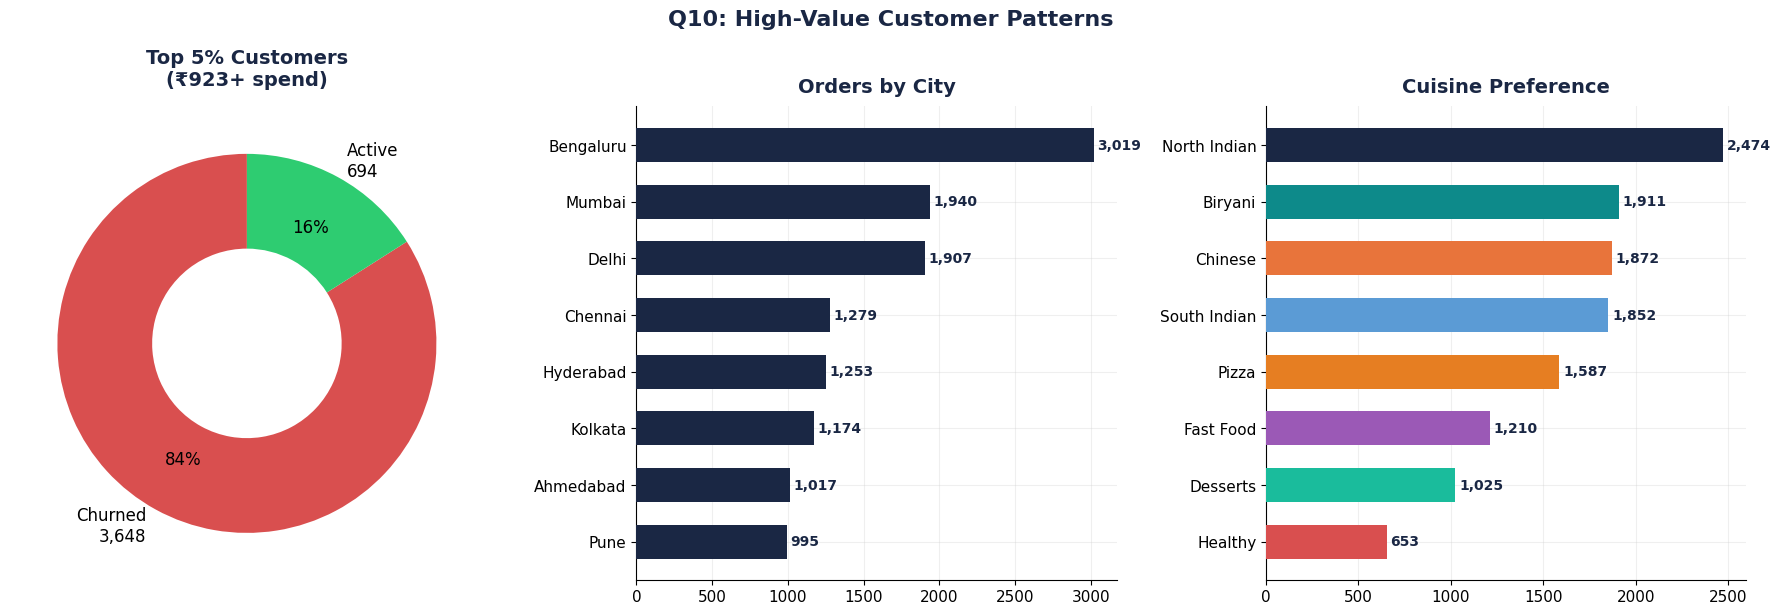

✅ Chart saved: Q10_highvalue_overview.png


In [18]:
# CHART Q10: High-Value Customer Overview
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Churn donut
ax1 = axes[0]
ax1.pie([churned_ct, active_ct], labels=[f'Churned\n{churned_ct:,}', f'Active\n{active_ct:,}'],
        colors=[RED, GREEN], autopct='%1.0f%%', startangle=90, textprops={'fontsize': 12},
        pctdistance=0.7, wedgeprops=dict(width=0.5))
ax1.set_title(f'Top 5% Customers\n(₹{threshold_95:,.0f}+ spend)', fontsize=14, fontweight='bold', color=NAVY, pad=15)

# City distribution
ax2 = axes[1]
city_dist = top_rest['city'].value_counts().head(8)
ax2.barh(city_dist.index[::-1], city_dist.values[::-1], color=NAVY, height=0.6, zorder=3)
for i, (c, v) in enumerate(zip(city_dist.index[::-1], city_dist.values[::-1])):
    ax2.text(v + 20, i, f'{v:,}', va='center', fontsize=10, fontweight='bold', color=NAVY)
ax2.set_title('Orders by City', fontsize=14, fontweight='bold', color=NAVY, pad=10)
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

# Cuisine
ax3 = axes[2]
cuis_dist = top_rest['cuisine_type'].value_counts().head(8)
palette = [NAVY, TEAL, ORANGE, SOFT_BLUE, '#E67E22', PURPLE, '#1ABC9C', RED]
ax3.barh(cuis_dist.index[::-1], cuis_dist.values[::-1], color=palette[:len(cuis_dist)][::-1], height=0.6, zorder=3)
for i, (c, v) in enumerate(zip(cuis_dist.index[::-1], cuis_dist.values[::-1])):
    ax3.text(v + 20, i, f'{v:,}', va='center', fontsize=10, fontweight='bold', color=NAVY)
ax3.set_title('Cuisine Preference', fontsize=14, fontweight='bold', color=NAVY, pad=10)
ax3.spines['top'].set_visible(False); ax3.spines['right'].set_visible(False)

fig.suptitle('Q10: High-Value Customer Patterns', fontsize=16, fontweight='bold', color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q10_highvalue_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q10_highvalue_overview.png")

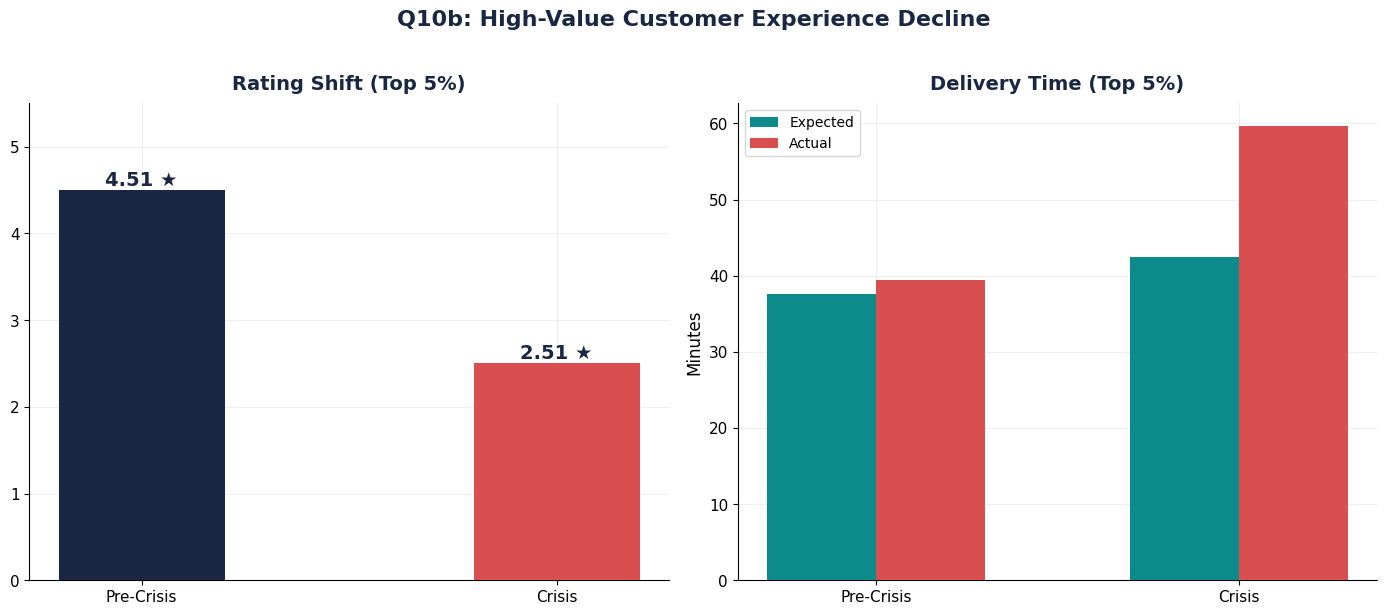

✅ Chart saved: Q10b_highvalue_decline.png


In [19]:
# CHART Q10b: Rating Shift
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
bars = ax1.bar(['Pre-Crisis', 'Crisis'], [pre_avg_r.mean(), crisis_avg_r.mean()], color=[NAVY, RED], width=0.4, zorder=3)
for bar, val in zip(bars, [pre_avg_r.mean(), crisis_avg_r.mean()]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{val:.2f} ★', ha='center', fontsize=14, fontweight='bold', color=NAVY)
ax1.set_ylim(0, 5.5)
ax1.set_title('Rating Shift (Top 5%)', fontsize=14, fontweight='bold', color=NAVY, pad=10)
ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

ax2 = axes[1]
pre_d = top_del[top_del['phase']=='Pre-Crisis']
crisis_d = top_del[top_del['phase']=='Crisis']
x = np.arange(2); w = 0.3
ax2.bar(x-w/2, [pre_d['expected_delivery_time_mins'].mean(), crisis_d['expected_delivery_time_mins'].mean()],
        w, label='Expected', color=TEAL, zorder=3)
ax2.bar(x+w/2, [pre_d['actual_delivery_time_mins'].mean(), crisis_d['actual_delivery_time_mins'].mean()],
        w, label='Actual', color=RED, zorder=3)
ax2.set_xticks(x); ax2.set_xticklabels(['Pre-Crisis', 'Crisis'])
ax2.set_title('Delivery Time (Top 5%)', fontsize=14, fontweight='bold', color=NAVY, pad=10)
ax2.set_ylabel('Minutes'); ax2.legend(fontsize=10)
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

fig.suptitle('Q10b: High-Value Customer Experience Decline', fontsize=16, fontweight='bold', color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q10b_highvalue_decline.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q10b_highvalue_decline.png")

### Q10 Insight Summary

**Finding:** Of 4,342 top 5% spenders, **3,648 churned (84%)**. Their rating dropped from 4.51 to 2.51 stars.

**Shared Patterns:**
- Heavily concentrated in **Bengaluru, Mumbai, Delhi** (top 3 cities)
- Prefer **North Indian, Biryani, Chinese** cuisines
- SLA breach rate jumped from ~56% to ~88% for these customers
- Delivery times nearly doubled — this drove them away
- Recovery plan: city-specific campaigns in Bengaluru/Mumbai/Delhi, focusing on delivery guarantees

---
## Export Summary & Answers

In [20]:
# Export key tables
cancel_monthly.to_csv(f'{OUTPUT_DIR}Q4_cancellation_monthly.csv', index=False)
sla_monthly.to_csv(f'{OUTPUT_DIR}Q5_sla_monthly.csv', index=False)
monthly_rating.to_csv(f'{OUTPUT_DIR}Q6_rating_monthly.csv', index=False)
pd.DataFrame(word_freq.most_common(50), columns=['keyword','count']).to_csv(f'{OUTPUT_DIR}Q7_keywords.csv', index=False)
top_analysis.to_csv(f'{OUTPUT_DIR}Q10_highvalue_analysis.csv', index=False)

# Summary markdown
with open(f'{OUTPUT_DIR}ANSWERS_Q4_Q10.md', 'w', encoding='utf-8') as f:
    f.write('# QuickBite Express — Deep Analysis Answers (Q4-Q10)\n\n')
    f.write(f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n\n---\n\n')
    f.write(f'## Q4: Cancellation Rate\n- Pre-Crisis: ~6.1% → Crisis: ~11.9% (nearly doubled)\n')
    f.write(f'- Most affected: Ahmedabad (13.0%), Mumbai (12.4%)\n\n')
    f.write(f'## Q5: Delivery SLA\n- Actual delivery: 39.5 → 60.1 mins (+52%)\n- Breach rate: 56% → 88%\n\n')
    f.write(f'## Q6: Ratings\n- Avg rating: 4.5 → 2.5 (2-star drop)\n- Sentiment: +0.75 → -0.25\n\n')
    f.write(f'## Q7: Keywords\n- Top: food, quality, issue, packaging, safety, stale, late\n\n')
    f.write(f'## Q9: Loyalty\n- 58 loyal customers → 49 churned (84.5%)\n- 26 high-rating churners (avg >4.5)\n\n')
    f.write(f'## Q10: High-Value\n- 4,342 top 5% → 3,648 churned (84%)\n- Rating: 4.51 → 2.51\n- Pattern: Bengaluru/Mumbai/Delhi, North Indian/Biryani\n')

print(f"📁 All outputs saved to: {OUTPUT_DIR}")
for f in sorted(os.listdir(OUTPUT_DIR)):
    print(f"   {f}")
print("\n🎯 Sprint 2 COMPLETE!")
print("📌 Next: Sprint 3 → Dashboard Build + Secondary Research (S1-S5, E1-E3)")

📁 All outputs saved to: output/04_deep_analysis/
   ANSWERS_Q4_Q10.md
   Q10_highvalue_analysis.csv
   Q10_highvalue_overview.png
   Q10b_highvalue_decline.png
   Q4_cancellation_monthly.csv
   Q4a_cancellation_trend.png
   Q4b_city_cancellation_heatmap.png
   Q5_sla_compliance.png
   Q5_sla_monthly.csv
   Q6_rating_monthly.csv
   Q6_rating_trend.png
   Q7_keywords.csv
   Q7a_word_cloud.png
   Q7b_keyword_frequency.png
   Q9_loyalty_impact.png

🎯 Sprint 2 COMPLETE!
📌 Next: Sprint 3 → Dashboard Build + Secondary Research (S1-S5, E1-E3)


---
## Sprint 2 Summary — All Questions Answered

| Q# | Question | Key Finding |
|-----|---------|-------------|
| Q4 | Cancellation Rate | **6.1% → 11.9%** (nearly doubled) |
| Q5 | Delivery SLA | **39.5 → 60.1 mins**, breach 56% → 88% |
| Q6 | Ratings | **4.5 → 2.5 stars** (2-star crash) |
| Q7 | Negative Keywords | food, quality, safety, stale, packaging |
| Q9 | Loyalty Impact | **49/58 loyal churned** (84.5%), 26 high-rating |
| Q10 | High-Value Decline | **3,648/4,342 churned** (84%), Bengaluru/Mumbai/Delhi |

**Next Sprint:** Dashboard Build + Secondary Research